<a href="https://colab.research.google.com/github/blakelobato/DS-Unit-2-Linear-Models/blob/master/module2-regression-2/212A_regression_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [70]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df['month_created'] = pd.to_datetime(df['created'])

In [0]:
df['month_created'] = df['month_created'].dt.month

In [73]:
df.month_created.describe()
#creates a new feature of months

count    48817.000000
mean         5.015486
std          0.824415
min          4.000000
25%          4.000000
50%          5.000000
75%          6.000000
max          6.000000
Name: month_created, dtype: float64

In [74]:
train.shape, test.shape

((31844, 37), (16973, 37))

In [0]:
#make bed to bath ratio feature
df['bed_bath_ratio'] = df['bedrooms'] / df['bathrooms']

In [0]:
#Make total rooms feature
df['total_rooms'] = df['bedrooms'] + df['bathrooms']

In [0]:
#df['dogs_and_cats'] = df[(df['cats_allowed'] != 0) & (df['dogs_allowed'] != 0)]


In [77]:
df.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,month_created,bed_bath_ratio,total_rooms
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2.0,4.5
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2.0,3.0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1.0,2.0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1.0,2.0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4.0,5.0


In [0]:
#creates our new train and test data
train = df.query('month_created <6')
test = df.query('month_created >=6')

In [79]:
train.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,month_created,bed_bath_ratio,total_rooms
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1.0,2.0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1.0,2.0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4.0,5.0
5,2.0,4,2016-04-19 04:24:47,,West 18th Street,40.7429,-74.0028,7995,350 West 18th Street,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2.0,6.0
6,1.0,2,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,40.8012,-73.9660,3600,210 West 107th Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2.0,3.0


In [80]:
test.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,month_created,bed_bath_ratio,total_rooms
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2.0,4.5
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,2.0,3.0
11,1.0,1,2016-06-03 03:21:22,Check out this one bedroom apartment in a grea...,W. 173rd Street,40.8448,-73.9396,1675,644 W. 173rd Street,low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1.0,2.0
14,1.0,1,2016-06-01 03:11:01,Spacious 1-Bedroom to fit King-sized bed comfo...,East 56th St..,40.7584,-73.9648,3050,315 East 56th St..,low,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1.0,2.0
24,2.0,4,2016-06-07 04:39:56,SPRAWLING 2 BEDROOM FOUND! ENJOY THE LUXURY OF...,W 18 St.,40.7391,-73.9936,7400,30 W 18 St.,medium,1,1,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,6,2.0,6.0


In [81]:
#begin with baseline or the mean for the target 'price'
train['price'].mean()

3575.604007034292

In [82]:
from sklearn.metrics import mean_absolute_error

#arrange y target vector
target = 'price'
y_train = train[target]
y_test = test[target]

#get mean baseline
print('Mean Baseline (using 0 features)')
guess = y_train.mean()

# Train Error
y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error (April and May Prices): {mae:.2f} dollars')

# Test Error
y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error (June Prices): {mae:.2f} dollars')

Mean Baseline (using 0 features)
Train Error (April and May Prices): 1201.88 dollars
Test Error (June Prices): 1197.71 dollars


In [83]:
#simple regression 1 feature
import pandas as pd
import plotly.express as px

px.scatter(
    train,
    x='bedrooms',
    y='price',
    text='month_created',
    title='Apartment Prices',
    trendline='ols',  # Ordinary Least Squares
)

In [100]:
# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
model = LinearRegression()

# 3. Arrange X features matrices (already did y target vectors)
features = ['total_rooms']
X_train = train[features]
X_test = test[features]
print(f'Linear Regression, dependent on: {features}')

# 4. Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f} dollars')

# 5. Apply the model to new data
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error: {mae:.2f} dollars')

Linear Regression, dependent on: ['total_rooms']
Train Error: 893.96 dollars
Test Error: 910.51 dollars


In [101]:
#better error numbers lets look at coefficents of the model equation
model.coef_, model.intercept_

(array([809.68138268]), 1363.4860214142823)

In [86]:
#multiple regressions
px.scatter_3d(
    train,
    x='bedrooms', 
    y='bathrooms', 
    z='price', 
    text='month_created', 
    title='NY Housing Prices'
)

In [87]:
train.head(2)

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space,month_created,bed_bath_ratio,total_rooms
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1.0,2.0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1.0,2.0


In [97]:
from sklearn.preprocessing import StandardScaler

# Re-arrange X features matrices
#make 12 features to use
features = [ 'bedrooms',
            'bathrooms',
            'dogs_allowed',
            'cats_allowed',
            'hardwood_floors',
            'laundry_in_building',
            'fitness_center',
            'balcony',
            'swimming_pool',
            'new_construction',
            'total_rooms',
            'high_speed_internet'
            ]
print(f'Linear Regression, dependent on: {features}')
X_train = train[features]
X_test = test[features]

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the model
model.fit(X_train_scaled, y_train)
y_pred_train = model.predict(X_train_scaled)
mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train error: {mae_train:.2f} dollars')

# Apply the model to new data
y_pred_test = model.predict(X_test_scaled)
mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test error: {mae_test:.2f} dollars')

Linear Regression, dependent on: ['bedrooms', 'bathrooms', 'dogs_allowed', 'cats_allowed', 'hardwood_floors', 'laundry_in_building', 'fitness_center', 'balcony', 'swimming_pool', 'new_construction', 'total_rooms', 'high_speed_internet']
Train error: 789.80 dollars
Test error: 794.83 dollars


In [99]:
#better error numbers lets look at coefficents of the model equation
model.coef_, model.intercept_

(array([ 4.28200292e+15,  1.83068746e+15,  1.20282227e+02, -5.73671875e+01,
         2.29375000e+01, -5.89050293e+01,  2.67914062e+02,  3.43906250e+01,
         2.87968750e+01, -8.03027344e+00, -5.47130696e+15, -7.43593750e+01]),
 3575.354806709948)

In [0]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def squared_errors(df, feature, target, m, b):
    """
    Visualize linear regression, with squared errors,
    in 2D: 1 feature + 1 target.
    
    Use the m & b parameters to "fit the model" manually.
    
    df : Pandas DataFrame
    feature : string, feature column in df
    target : string, target column in df
    m : numeric, slope for linear equation
    b : numeric, intercept for linear requation
    """
    
    # Plot data
    fig = plt.figure(figsize=(7,7))
    ax = plt.axes()
    df.plot.scatter(feature, target, ax=ax)
    
    # Make predictions
    x = df[feature]
    y = df[target]
    y_pred = m*x + b
    
    # Plot predictions
    ax.plot(x, y_pred)
    
    # Plot squared errors
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    scale = (xmax-xmin)/(ymax-ymin)
    for x, y1, y2 in zip(x, y, y_pred):
        bottom_left = (x, min(y1, y2))
        height = abs(y1 - y2)
        width = height * scale
        ax.add_patch(Rectangle(xy=bottom_left, width=width, height=height, alpha=0.1))
    
    # Print regression metrics
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print('Mean Squared Error:', mse)
    print('Root Mean Squared Error:', rmse)
    print('Mean Absolute Error:', mae)
    print('R^2:', r2)

Mean Squared Error: 1798035.1108607587
Root Mean Squared Error: 1340.9083156057907
Mean Absolute Error: 893.5369457354603
R^2: 0.420927932151972


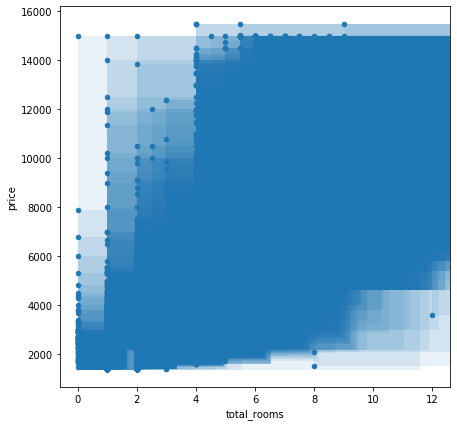

In [105]:
squared_errors(train, 'total_rooms',target, m=809, b=1363)

In [107]:

# X is a matrix. Add column of constants for fitting the intercept.
def add_constant(X):
    constant = np.ones(shape=(len(X),1))
    return np.hstack((constant, X))
X = add_constant(train[features].values)
print('X')
print(X)

# y is a column vector
y = train[target].values[:, np.newaxis]
print('y')
print(y)

# Least squares solution in code
X_transpose = X.T
X_transpose_X = X_transpose @ X
X_transpose_X_inverse = np.linalg.inv(X_transpose_X)
X_transpose_y = X_transpose @ y
beta_hat = X_transpose_X_inverse @ X_transpose_y

print('Beta Hat')
print(beta_hat)

X
[[1. 2.]
 [1. 2.]
 [1. 5.]
 ...
 [1. 2.]
 [1. 1.]
 [1. 3.]]
y
[[2850]
 [3275]
 [3350]
 ...
 [2595]
 [3350]
 [2200]]
Beta Hat
[[1363.48602141]
 [ 809.68138268]]


In [0]:
# Arrange X features matrix & y target vector
features = ['total_rooms']
target = 'price'
X = df[features]
y = df[target]

In [110]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25,
                                                    random_state=11)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36612, 1) (12205, 1) (36612,) (12205,)


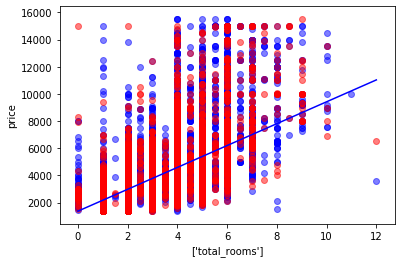

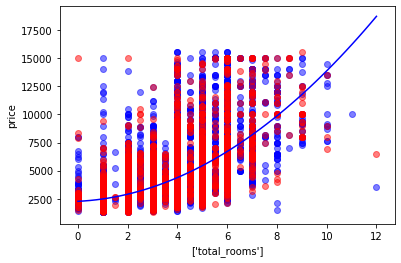

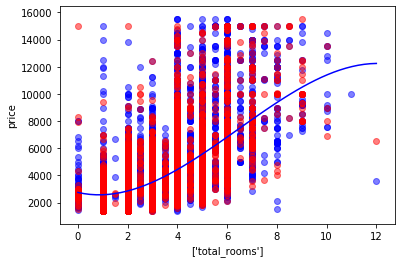

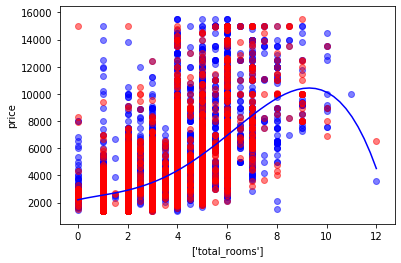

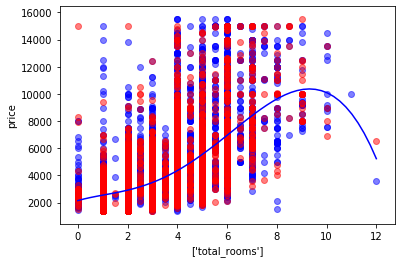

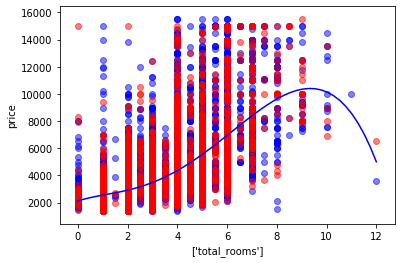

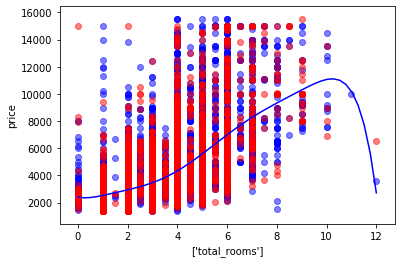

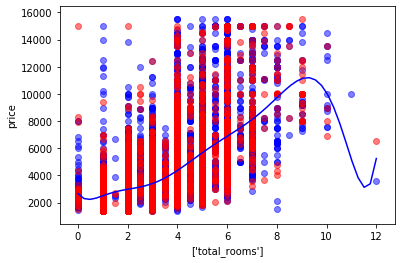

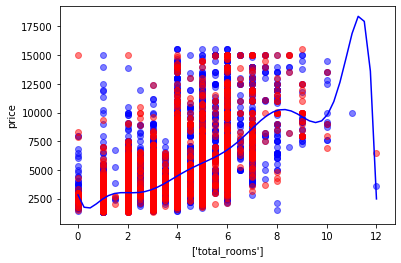

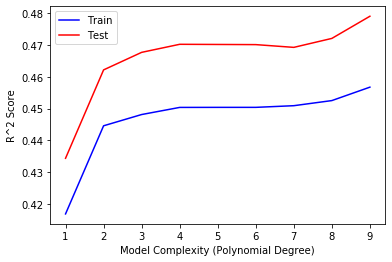

In [111]:
from IPython.display import display, HTML
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures


# Credit for PolynomialRegression: Jake VanderPlas, Python Data Science Handbook, Chapter 5.3
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), 
                         LinearRegression(**kwargs))

polynomial_degrees = range(1, 10, 1)
train_r2s = []
test_r2s = []

for degree in polynomial_degrees:
    model = PolynomialRegression(degree)
    display(HTML(f'Polynomial degree={degree}'))
    
    model.fit(X_train, y_train)
    train_r2 = model.score(X_train, y_train)
    test_r2 = model.score(X_test, y_test)
    display(HTML(f'<b style="color: blue">Train R2 {train_r2:.2f}</b>'))
    display(HTML(f'<b style="color: red">Test R2 {test_r2:.2f}</b>'))

    plt.scatter(X_train, y_train, color='blue', alpha=0.5)
    plt.scatter(X_test, y_test, color='red', alpha=0.5)
    plt.xlabel(features)
    plt.ylabel(target)
    
    x_domain = np.linspace(X.min(), X.max())
    curve = model.predict(x_domain)
    plt.plot(x_domain, curve, color='blue')
    plt.show()
    display(HTML('<hr/>'))
    
    train_r2s.append(train_r2)
    test_r2s.append(test_r2)
    
display(HTML('Validation Curve'))
plt.plot(polynomial_degrees, train_r2s, color='blue', label='Train')
plt.plot(polynomial_degrees, test_r2s, color='red', label='Test')
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()